# 📰 Clasificación de Noticias Españolas

Este proyecto analiza noticias en español para predecir si pertenecen a la categoría de **Macroeconomía** o a otras categorías.

## 🎯 Objetivo
Crear un modelo que pueda leer una noticia y determinar automáticamente si es sobre temas económicos o no.

##  Módulo 0 – Instalación y configuración (opcional en Colab)

In [1]:
# 📁 Manipulación de archivos
import os

# 📦 KaggleHub para descargar datasets
import kagglehub

# 📊 Procesamiento de datos
import pandas as pd
import numpy as np

# 🧹 NLP con NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import unicodedata
import shutil
# 🔢 Modelado y vectorización
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 📂 Obtener los datos

En esta sección descargamos un conjunto de noticias en español que ya están clasificadas por categorías. Esto nos servirá para entrenar nuestro modelo.

In [2]:
# Descargar dataset (esto lo guarda en ~/.cache)
origen = kagglehub.dataset_download("kevinmorgado/spanish-news-classification")
proyecto_dir = r"C:\Users\felip\Desktop\Codigos\Ciencia De Datos - T3"
# Copiar los archivos del dataset al proyecto
destino = os.path.join(proyecto_dir, "spanish-news-classification")
shutil.copytree(origen, destino, dirs_exist_ok=True)

df_path = "spanish-news-classification\df_total.csv"

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\felip\AppData\Local\Temp\ipykernel_27344\2144718790.py:8: SyntaxWarning: invalid escape sequence '\d'
  df_path = "spanish-news-classification\df_total.csv"


In [3]:
#OBJETIVO: PREDECIR SI LA SECCION SERA DE ECONOMIA O NO


df = pd.read_csv(df_path)


# Ver número de registros
print("Total de noticias:", len(df))
# Ver categorías disponibles
print("Categorías únicas:", df['Type'].unique())
# Cantidad por categoría
df['Type'].value_counts()
df.head()

Total de noticias: 1217
Categorías únicas: ['Otra' 'Regulaciones' 'Alianzas' 'Macroeconomia' 'Innovacion'
 'Sostenibilidad' 'Reputacion']


,url,news,Type
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra
1,https://www.larepublica.co/redirect/post/3210288,El regulador de valores de China dijo el domin...,Regulaciones
2,https://www.larepublica.co/redirect/post/3240676,En una industria históricamente masculina como...,Alianzas
3,https://www.larepublica.co/redirect/post/3342889,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,https://www.larepublica.co/redirect/post/3427208,Ayer en Cartagena se dio inicio a la versión n...,Otra


## 🔍 Explorar los datos

Vamos a ver qué tipo de noticias tenemos y cuántas hay de cada categoría.

In [4]:
import re
import unicodedata

stopwords_esp = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = re.sub(r"http\S+|www.\S+", "", texto)
    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    texto = re.sub(r'[^a-zñ\s]', '', texto)
    tokens = texto.split()  # Usa split en lugar de word_tokenize
    tokens = [t for t in tokens if t not in stopwords_esp]
    return ' '.join(tokens)


## 🧹 Limpiar el texto

Las noticias vienen con muchos caracteres especiales, acentos, enlaces y palabras comunes (como "el", "la", "de") que no aportan información útil. Aquí creamos una función para limpiar todo eso y dejar solo las palabras importantes.

In [5]:
#quitamos la url que no ocuparemos
df = df.drop(columns=['url'])


## 🎯 Preparar los datos para el modelo

Ahora vamos a simplificar nuestro problema: en lugar de predecir entre muchas categorías, solo vamos a predecir si una noticia es de "Macroeconomía" o no.

In [6]:
#Colocaremos una nueva columna que nos dira si la categoria es de macroeconomia o no lo es
df['target'] = df['Type'].apply(lambda x: 1 if x == 'Macroeconomia' else 0)

In [7]:
#limpieza
df['clean_news'] = df['news'].apply(limpiar_texto)

In [8]:
df.head()


,news,Type,target,clean_news
0,Durante el foro La banca articulador empresari...,Otra,0,foro banca articulador empresarial desarrollo ...
1,El regulador de valores de China dijo el domin...,Regulaciones,0,regulador valores china dijo domingo buscara c...
2,En una industria históricamente masculina como...,Alianzas,0,industria historicamente masculina aviacion vi...
3,Con el dato de marzo el IPC interanual encaden...,Macroeconomia,1,dato marzo ipc interanual encadena decimoquint...
4,Ayer en Cartagena se dio inicio a la versión n...,Otra,0,ayer cartagena dio inicio version numero conve...


In [21]:
from sklearn.metrics import classification_report, accuracy_score

def entrenar_y_evaluar_completo(X_texto, y, nombre="modelo"):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.naive_bayes import MultinomialNB

    X_train, X_test, y_train, y_test = train_test_split(X_texto, y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    modelo = MultinomialNB()
    modelo.fit(X_train_vec, y_train)
    y_pred = modelo.predict(X_test_vec)

    reporte = classification_report(y_test, y_pred, output_dict=True)
    reporte_flat = {
        "modelo": nombre,
        "accuracy": accuracy_score(y_test, y_pred),
    }

    for clase, metricas in reporte.items():
        if isinstance(metricas, dict):  # evita error en "accuracy"
            for metrica, valor in metricas.items():
                reporte_flat[f"{clase}_{metrica}"] = valor

    return reporte_flat


## 🤖 Crear una función para entrenar modelos

Esta función nos permitirá entrenar diferentes versiones de nuestro modelo y ver qué tan bien funcionan. Es como un "molde" que podemos reutilizar.

🔢 Forma del dataset: (1217, 4)

📊 Clases únicas en 'Type': ['Otra' 'Regulaciones' 'Alianzas' 'Macroeconomia' 'Innovacion'
 'Sostenibilidad' 'Reputacion']

📊 Distribución de clases:
Type
Macroeconomia     340
Alianzas          247
Innovacion        195
Regulaciones      142
Sostenibilidad    137
Otra              130
Reputacion         26
Name: count, dtype: int64

📊 Distribución binaria (Macroeconomia vs otras):
target
0    877
1    340
Name: count, dtype: int64


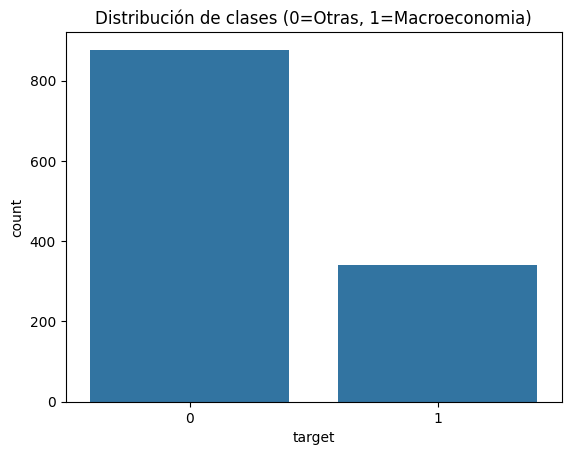

In [10]:
#DATASET DE TRABAJO
print("🔢 Forma del dataset:", df.shape)
print("\n📊 Clases únicas en 'Type':", df['Type'].unique())
print("\n📊 Distribución de clases:")
print(df['Type'].value_counts())

print("\n📊 Distribución binaria (Macroeconomia vs otras):")
print(df['target'].value_counts())

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='target')
plt.title("Distribución de clases (0=Otras, 1=Macroeconomia)")
plt.show()


## 📊 Analizar nuestros datos

Antes de entrenar el modelo, es importante entender qué tenemos: cuántas noticias hay de cada tipo y cómo están distribuidas.

In [11]:
df['text_len'] = df['news'].apply(lambda x: len(str(x).split()))
df['clean_len'] = df['clean_news'].apply(lambda x: len(str(x).split()))
print("\n📝 Estadísticas longitud original:")
print(df['text_len'].describe())

print("\n🧼 Estadísticas longitud texto limpio:")
print(df['clean_len'].describe())




📝 Estadísticas longitud original:
count    1217.000000
mean      516.549712
std       359.545475
min         0.000000
25%       265.000000
50%       445.000000
75%       667.000000
max      2964.000000
Name: text_len, dtype: float64

🧼 Estadísticas longitud texto limpio:
count    1217.000000
mean      270.334429
std       186.172451
min         0.000000
25%       138.000000
50%       235.000000
75%       341.000000
max      1536.000000
Name: clean_len, dtype: float64


### 📏 ¿Qué tan largas son las noticias?

Vamos a ver cuántas palabras tienen las noticias antes y después de limpiarlas.

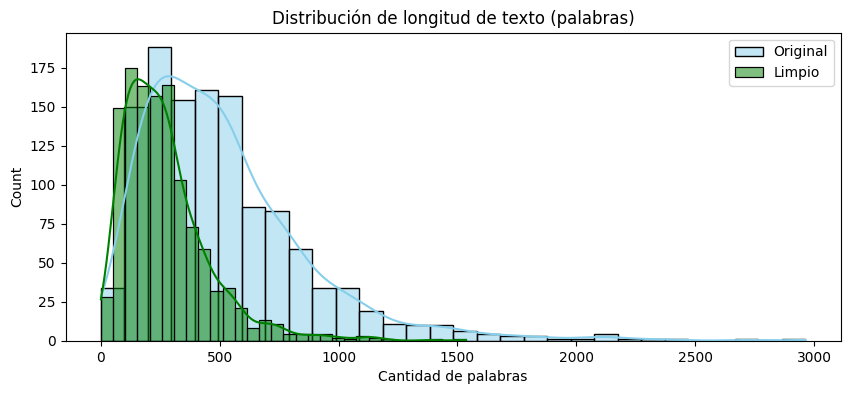

In [12]:
plt.figure(figsize=(10, 4))
sns.histplot(df['text_len'], bins=30, color='skyblue', label='Original', kde=True)
sns.histplot(df['clean_len'], bins=30, color='green', label='Limpio', kde=True)
plt.legend()
plt.title("Distribución de longitud de texto (palabras)")
plt.xlabel("Cantidad de palabras")
plt.show()


In [25]:
# Variables objetivo
y = df['target']

#MODELO SIN Iteración de mejora: lematización, filtrado por POS, ajustes de hiper‑parámetros.

# Caso 1: Texto original sin limpiar
entrenar_y_evaluar(df['news'], y, nombre="Texto original (news)")

# Caso 2: Texto limpio
entrenar_y_evaluar(df['clean_news'], y, nombre="Texto limpio (clean_news)")



📊 Texto original (news)
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       171
           1       1.00      0.16      0.28        73

    accuracy                           0.75       244
   macro avg       0.87      0.58      0.57       244
weighted avg       0.82      0.75      0.68       244

Confusion Matrix:
 [[171   0]
 [ 61  12]]

📊 Texto limpio (clean_news)
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       171
           1       0.98      0.59      0.74        73

    accuracy                           0.87       244
   macro avg       0.91      0.79      0.83       244
weighted avg       0.89      0.87      0.86       244

Confusion Matrix:
 [[170   1]
 [ 30  43]]


{'modelo': 'Texto limpio (clean_news)',
 'accuracy': 0.8729508196721312,
 'f1': np.float64(0.7350427350427351)}

<Figure size 1200x700 with 0 Axes>

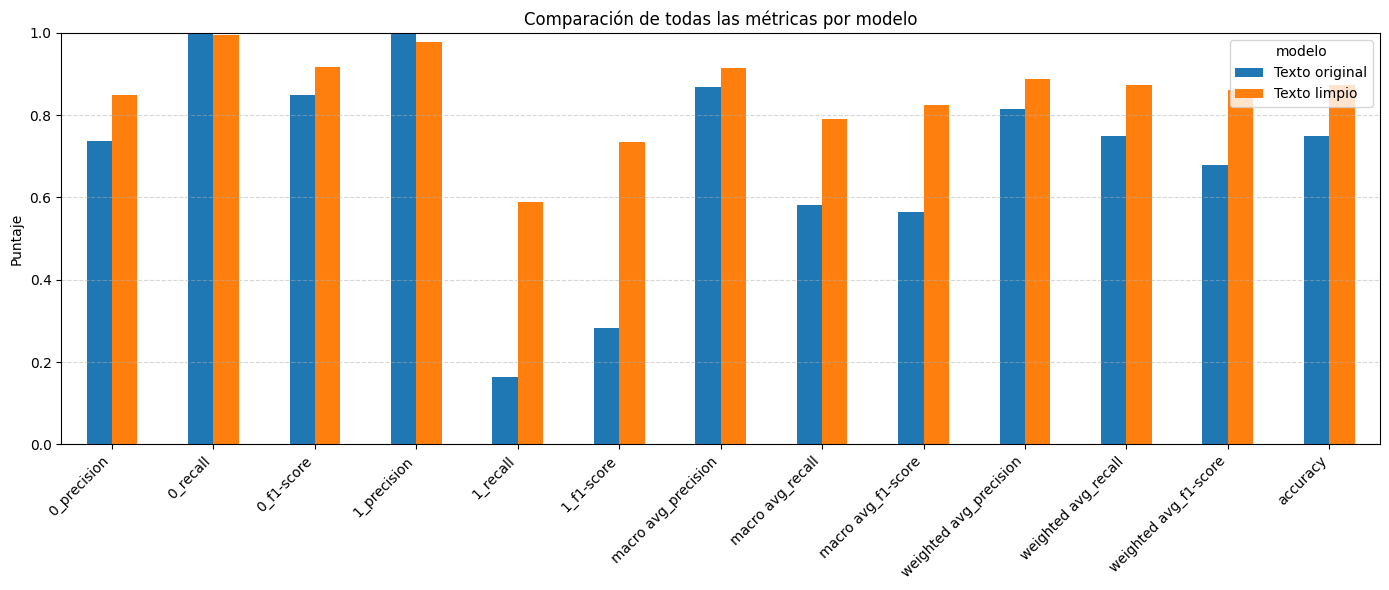

In [26]:
import matplotlib.pyplot as plt

# Seleccionamos solo algunas columnas claves
metricas_a_graficar = [
    "0_precision", "0_recall", "0_f1-score",
    "1_precision", "1_recall", "1_f1-score",
    "macro avg_precision", "macro avg_recall", "macro avg_f1-score",
    "weighted avg_precision", "weighted avg_recall", "weighted avg_f1-score",
    "accuracy"
]

df_plot = df_res[metricas_a_graficar].transpose()

# Graficar
plt.figure(figsize=(12, 7))
df_plot.plot(kind='bar', figsize=(14,6))
plt.title("Comparación de todas las métricas por modelo")
plt.ylabel("Puntaje")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 🥊 Primera prueba: Texto original vs texto limpio

Vamos a entrenar dos modelos básicos para ver si limpiar el texto realmente ayuda a predecir mejor.

In [14]:
#MODELO ENTRENADO CON HIPERPARAMETROS TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    ngram_range=(1, 2),
    max_features=5000
)


## 🚀 Modelo mejorado con configuraciones especiales

Ahora vamos a usar configuraciones más avanzadas para hacer que nuestro modelo sea más inteligente al analizar el texto.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df['clean_news'], df['target'], test_size=0.2, random_state=42)

# Vectorización
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modelo
modelo = MultinomialNB(alpha=0.5)
modelo.fit(X_train_vec, y_train)

# Predicción y evaluación
y_pred = modelo.predict(X_test_vec)

print("📊 Resultados del modelo con clean_news + TF-IDF mejorado:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


📊 Resultados del modelo con clean_news + TF-IDF mejorado:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       171
           1       0.86      0.86      0.86        73

    accuracy                           0.92       244
   macro avg       0.90      0.90      0.90       244
weighted avg       0.92      0.92      0.92       244

Confusion Matrix:
 [[161  10]
 [ 10  63]]


✅ Sin TF-IDF (original): acc=0.91 | f1=0.85
✅ Sin TF-IDF (limpio): acc=0.91 | f1=0.86
✅ Sin TF-IDF (limpio): acc=0.91 | f1=0.86
✅ Con TF-IDF (original): acc=0.91 | f1=0.85
✅ Con TF-IDF (original): acc=0.91 | f1=0.85
✅ Con TF-IDF (limpio): acc=0.92 | f1=0.86

📋 Resultados comparativos:
✅ Con TF-IDF (limpio): acc=0.92 | f1=0.86

📋 Resultados comparativos:


,modelo,accuracy,1_precision,1_recall,1_f1-score,macro avg_f1-score
0,Sin TF-IDF (original),0.909836,0.840000,0.863014,0.851351,0.893323
1,Sin TF-IDF (limpio),0.913934,0.842105,0.876712,0.859060,0.898557
2,Con TF-IDF (original),0.909836,0.849315,0.849315,0.849315,0.892494
3,Con TF-IDF (limpio),0.918033,0.863014,0.863014,0.863014,0.902267


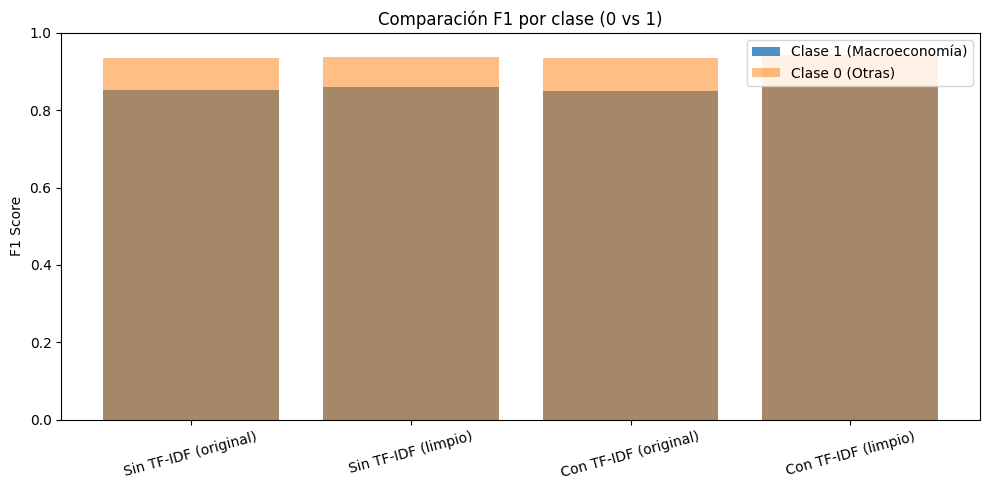

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------
# FUNCIÓN BASE
# ---------------------

def entrenar_modelo_completo(X_text, y, vectorizador_func, nombre="modelo"):
    X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

    vectorizador = vectorizador_func()
    X_train_vec = vectorizador.fit_transform(X_train)
    X_test_vec = vectorizador.transform(X_test)

    modelo = MultinomialNB(alpha=0.5)
    modelo.fit(X_train_vec, y_train)
    y_pred = modelo.predict(X_test_vec)

    # Reporte detallado
    reporte = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    resultados = {
        "modelo": nombre,
        "accuracy": accuracy
    }

    for etiqueta, metricas in reporte.items():
        if isinstance(metricas, dict):  # Evita el error con 'accuracy'
            for metrica, valor in metricas.items():
                resultados[f"{etiqueta}_{metrica}"] = valor

    print(f"✅ {nombre}: acc={accuracy:.2f} | f1={reporte['1']['f1-score']:.2f}")
    return resultados

# ---------------------
# PREPARACIÓN
# ---------------------

y = df["target"]
resultados = []

# ---------------------
# EXPERIMENTOS
# ---------------------

resultados.append(entrenar_modelo_completo(df['news'], y,
    vectorizador_func=lambda: CountVectorizer(),
    nombre="Sin TF-IDF (original)"
))

resultados.append(entrenar_modelo_completo(df['clean_news'], y,
    vectorizador_func=lambda: CountVectorizer(),
    nombre="Sin TF-IDF (limpio)"
))

resultados.append(entrenar_modelo_completo(df['news'], y,
    vectorizador_func=lambda: TfidfVectorizer(
        max_df=0.95, min_df=2, ngram_range=(1, 2), max_features=5000
    ),
    nombre="Con TF-IDF (original)"
))

resultados.append(entrenar_modelo_completo(df['clean_news'], y,
    vectorizador_func=lambda: TfidfVectorizer(
        max_df=0.95, min_df=2, ngram_range=(1, 2), max_features=5000
    ),
    nombre="Con TF-IDF (limpio)"
))

# ---------------------
# CREAR DATAFRAME
# ---------------------

df_resultados = pd.DataFrame(resultados)

# Mostrar resumen comparativo
print("\n📋 Resultados comparativos:")
display(df_resultados[['modelo', 'accuracy', '1_precision', '1_recall', '1_f1-score', 'macro avg_f1-score']])

# ---------------------
# GRAFICAR F1 por clase
# ---------------------

plt.figure(figsize=(10,5))
plt.bar(df_resultados['modelo'], df_resultados['1_f1-score'], label='Clase 1 (Macroeconomía)', alpha=0.8)
plt.bar(df_resultados['modelo'], df_resultados['0_f1-score'], label='Clase 0 (Otras)', alpha=0.5)
plt.ylabel("F1 Score")
plt.title("Comparación F1 por clase (0 vs 1)")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


## 🎉 Conclusiones

Al final de este análisis podremos ver:
- ✅ Si limpiar el texto mejora las predicciones
- ✅ Qué técnicas funcionan mejor para clasificar noticias de economía
- ✅ Qué tan preciso es nuestro modelo para detectar noticias económicas

¡Los resultados aparecerán en la tabla y gráfico de abajo!

## 📈 Comparación final: ¿Cuál funciona mejor?

Vamos a probar diferentes combinaciones para ver cuál es la mejor forma de clasificar las noticias. Compararemos:
- Texto original vs texto limpio
- Con y sin técnicas avanzadas de análisis (TF-IDF)